In [1]:
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from jansen_linkage import jansenLinkage

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.ioff()
%matplotlib inline

## Utilities to build the Newton-Euler system of equations

### Variable order (along matrix row)
$F_{0,1}$, $F_{0,3}$, $F_{0,5}$, $F_{1,2}$, $F_{1,7}$, $F_{2,3}$, $F_{3,4}$, $F_{4,6}$, $F_{5,6}$, $F_{6,7}$

### Equation order (along matrix column)
- All X force balance (1- 7)
- All Y force balance (1- 7)
- All moment balance  (1- 7)

In [2]:
force_idx = [(0, 1),
             (0, 3),
             (0, 5),
             (1, 2), 
             (1, 7), 
             (2, 3),
             (3, 4),
             (4, 6), 
             (5, 6),
             (6, 7)]

# correspond to intersections in force_idx
joints = ["p3",
          "p0",
          "p0",
          "p1",
          "p1",
          "p2", 
          "p4",
          "p6",
          "p5",
          "p5"]


zs = np.zeros((7, 10))

for i in range(7):
    for j in range(10):
        if(i+1 == force_idx[j][0]):
            zs[i][j] = -1.0
        if(i+1 == force_idx[j][1]):
            zs[i][j] = 1.0


B = np.zeros((21,21))

B[0:7, 0:10] = zs
B[7:14, 10:20] = zs
B[14:21, 0:10] = -zs
B[14:21, 10:20] = zs

## Defining Masses and Moments of inertias
Note: (All quantities in SI units)
- Lengths are in m
- Angles in rad
- Mass in kg
- MOI in kg$\text{m}^2$
- Forces in N
- Moments in Nm 

In [3]:
## Functions to compute mass and moi
def triangle_ar(a, b, c):
    s = (a+b+c)/2
    ar = np.sqrt((s)*(s-a)*(s-b)*(s-c))
    return ar

def line_ar(l, w):
    return l*w

def triangle_moi(a, b, c, rho):

    ar = triangle_ar(a,b,c)
    h = ar*2/b
    x = np.sqrt(a**2 - h**2)

    Ix = b*(h**3)/36
    Iy = ((b**3)*h - (b**2)*h*x + b*h*(x**2))/36
    Iz = Ix+Iy

    return rho*Iz

def line_moi(l, w, rho):

    Ix = (w**3)*l/12
    Iy = (l**3)*w/12
    Iz = Ix+Iy
    
    return rho*Iz

In [4]:
tn = 0.17991304966866345
links = {'b': 1e-3*84.0887361545927,
         'c': 1e-3*77.90915110877397,
         'd': 1e-3*70.0,
         'e': 1e-3*105.97850347954511,
         'f': 1e-3*77.53549034841403,
         'g': 1e-3*64.19328837360202,
         'h': 1e-3*125.84909456724523, 
         'i': 1e-3*97.83881139172232, 
         'j': 1e-3*100.11359491698461, 
         'k': 1e-3*122.03808366722906, 
         'n': 1e-3*77.33771995126325, 
         'm': 1e-3*30.594483124304126}

# link: mass
width = 1e-3*15.0 # width of a binary link
height = 1e-3*10.0 # height of a binary link
rho = 1300.0 # mass/unit area kg/m3


mass =  { 1: rho*height*line_ar(links["m"], width),
          2: rho*height*line_ar(links["j"], width),
          3: rho*height*triangle_ar(links["b"], links["d"], links["e"]),
          4: rho*height*line_ar(links["f"], width),
          5: rho*height*line_ar(links["c"], width),
          6: rho*height*triangle_ar(links["g"], links["h"], links["i"]),
          7: rho*height*line_ar(links["k"], width)}

# link : moi
moi =   { 1: line_moi(links["m"], width, rho*height),
          2: line_moi(links["j"], width, rho*height),
          3: triangle_moi(links["b"], links["d"], links["e"], rho*height),
          4: line_moi(links["f"], width, rho*height),
          5: line_moi(links["c"], width, rho*height),
          6: triangle_moi(links["g"], links["h"], links["i"], rho*height),
          7: line_moi(links["k"], width, rho*height)}

print(mass)

{1: 0.005965924209239305, 2: 0.019522151008811998, 3: 0.03818482043842563, 4: 0.015119420617940737, 5: 0.015192284466210924, 6: 0.04022436658466115, 7: 0.023797426315109668}


In [5]:
### Force profiles at p7 coupler point
def fp7(angle, start, end):
    if(250*np.pi/180>angle>120*np.pi/180):
        return [0.0, 0.0]       
    else:
        return [5, 10]

In [6]:
jl = jansenLinkage(links=links, tn=tn)
com = [None for i in range(8)]
grav = 9.8 # m/s2

force_results = {"f01":[],
                 "f03":[],
                 "f05":[],
                 "f12":[],
                 "f17":[],
                 "f23":[],
                 "f34":[],
                 "f46":[],
                 "f56":[],
                 "f67":[],
                 "t01":[]}

tm_arr = np.linspace(0, 360, 360)*np.pi/180
for tm in tm_arr:
    
    wm = 1
    wn = 0
    am = 0
    an = 0

    # kinematic analysis
    pos, vel, acc, points = jl.kinematic_analysis(tm, wm, wn, am, an)
    
    # compute COM (pos, acc, vel)
    com[1] = (points["p1"] + points["p3"])/2
    com[2] = (points["p1"] + points["p2"])/2
    com[3] = (points["p0"] + points["p2"] + points["p4"])/3
    com[4] = (points["p4"] + points["p6"])/2
    com[5] = (points["p0"] + points["p5"])/2
    com[6] = (points["p5"] + points["p6"] + points["p7"])/3
    com[7] = (points["p1"] + points["p5"])/2

    # compute contact forces at p7 (coupler point)
    fp7x, fp7y = fp7(angle=tm, start=(250-360)*np.pi, end=120*np.pi)

    # compute RHS
    mass_vec = [mass[1]*com[1].acc[0],
                mass[2]*com[2].acc[0],
                mass[3]*com[3].acc[0],
                mass[4]*com[4].acc[0],
                mass[5]*com[5].acc[0],
                mass[6]*com[6].acc[0] - fp7x,
                mass[7]*com[7].acc[0],
                mass[1]*(com[1].acc[1] + grav),
                mass[2]*(com[2].acc[1] + grav),
                mass[3]*(com[3].acc[1] + grav),
                mass[4]*(com[4].acc[1] + grav),
                mass[5]*(com[5].acc[1] + grav),
                mass[6]*(com[6].acc[1] + grav) - fp7y,
                mass[7]*(com[7].acc[1] + grav),
                moi[1]*acc["am"],
                moi[2]*acc["aj"],
                moi[3]*acc["ab"],
                moi[4]*acc["af"],
                moi[5]*acc["ac"],
                moi[6]*acc["ai"] - ((points["p7"].pos[0]-com[6].pos[1])*fp7y - (points["p7"].pos[1]-com[6].pos[1])*fp7x),
                moi[7]*acc["ak"]]

    # compute LHS
    A = B.copy()

    for i in range(7):
        for j in range(10):
            A[i+14][j]    *= (points[joints[j]].pos[1] - com[i+1].pos[1])
            A[i+14][j+10] *= (points[joints[j]].pos[0] - com[i+1].pos[0])
            
    # Input torque term
    A[14][20] = 1.0

    # Solution
    forces = np.linalg.solve(A, mass_vec)
    for i, fi in enumerate(force_idx):
        force_results[f"f{fi[0]}{fi[1]}"].append([forces[i], forces[i+10]])
    force_results["t01"].append(forces[20])

for di in force_results:
    force_results[di] = np.array(force_results[di])

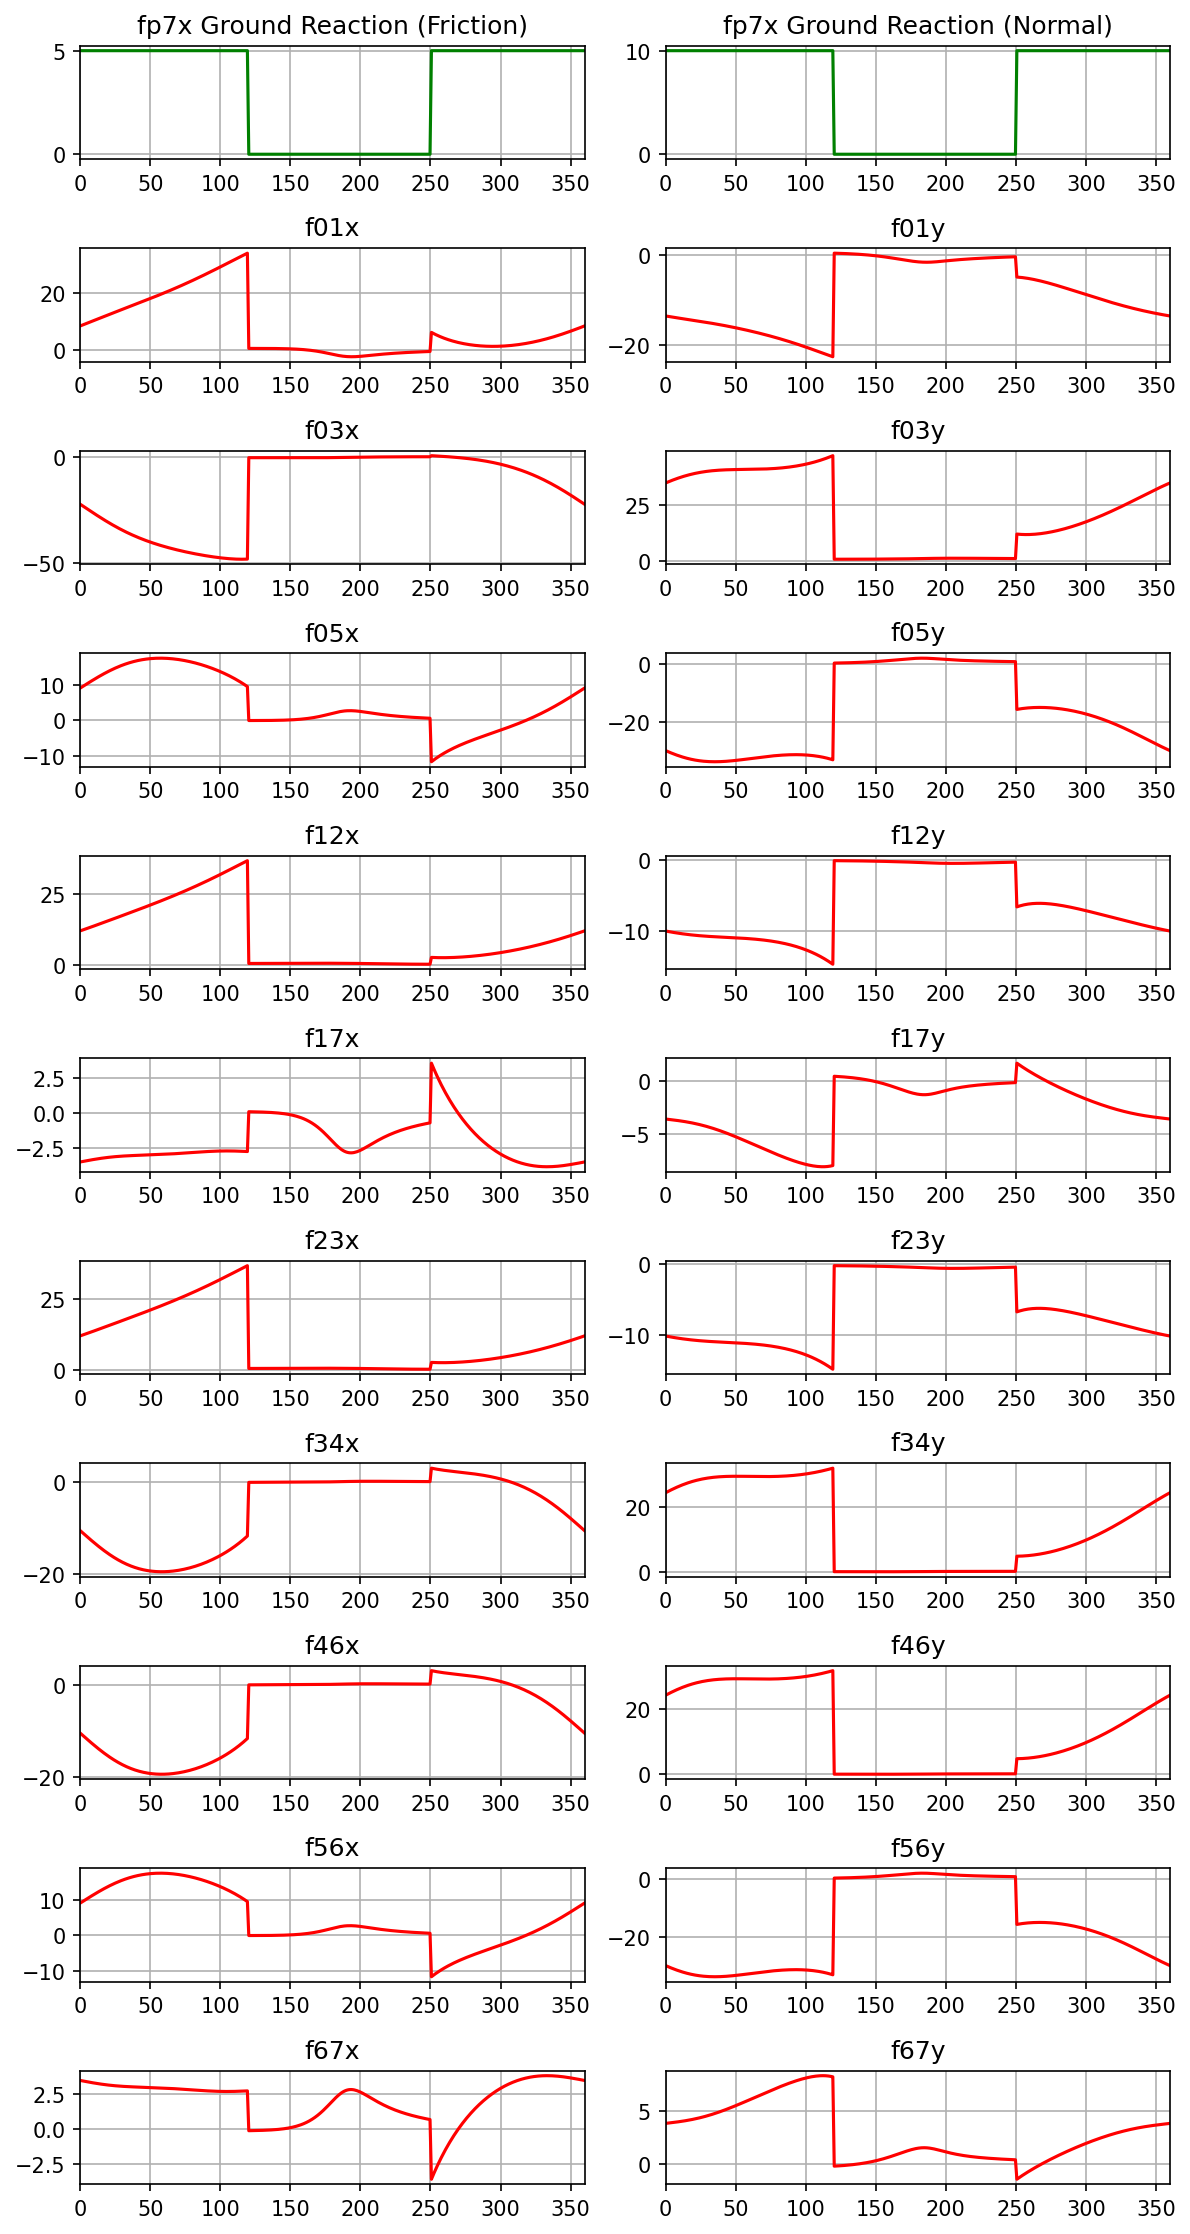

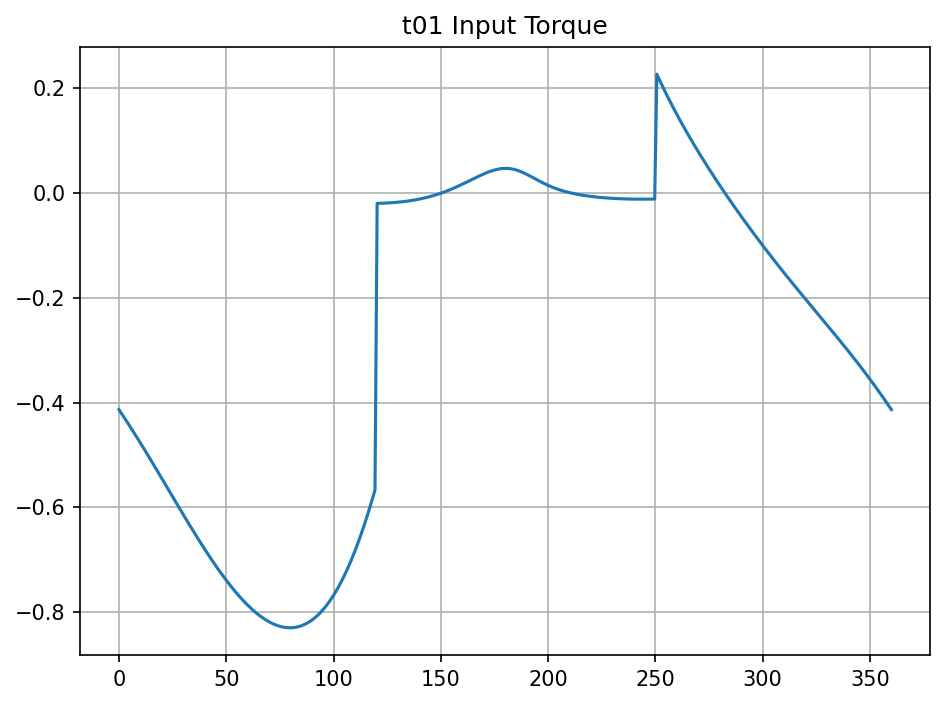

In [7]:
# Force plots
f, axs = plt.subplots(11, 2, figsize=(8, 15))

fp7x = [fp7(angle=tm, start=(250-360)*np.pi, end=120*np.pi)[0] for tm in tm_arr]
fp7y = [fp7(angle=tm, start=(250-360)*np.pi, end=120*np.pi)[1] for tm in tm_arr]

plt.subplot(11,2,1)
plt.title(f"fp7x Ground Reaction (Friction)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, fp7x, "g")

plt.subplot(11,2,2)
plt.title(f"fp7x Ground Reaction (Normal)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, fp7y, "g")

    

for i, di in enumerate(force_results):
    if(di == "t01"):
        continue
    plt.subplot(11,2,2*i+1+2)
    plt.title(f"{di}x")
    plt.grid("on")
    plt.xlim([0, 360])
    plt.plot(tm_arr*180/np.pi, force_results[di][:, 0], "r")
    
    plt.subplot(11,2,2*i+2+2)
    plt.title(f"{di}y")
    plt.grid("on")
    plt.xlim([0, 360])
    plt.plot(tm_arr*180/np.pi, force_results[di][:, 1], "r")

plt.savefig("../outputs/dynamic_analysis/force_plots.png")

plt.figure()
plt.title("t01 Input Torque")
plt.grid("on")
plt.plot(tm_arr*180/np.pi,force_results["t01"])
plt.savefig("../outputs/dynamic_analysis/input_torque.png")

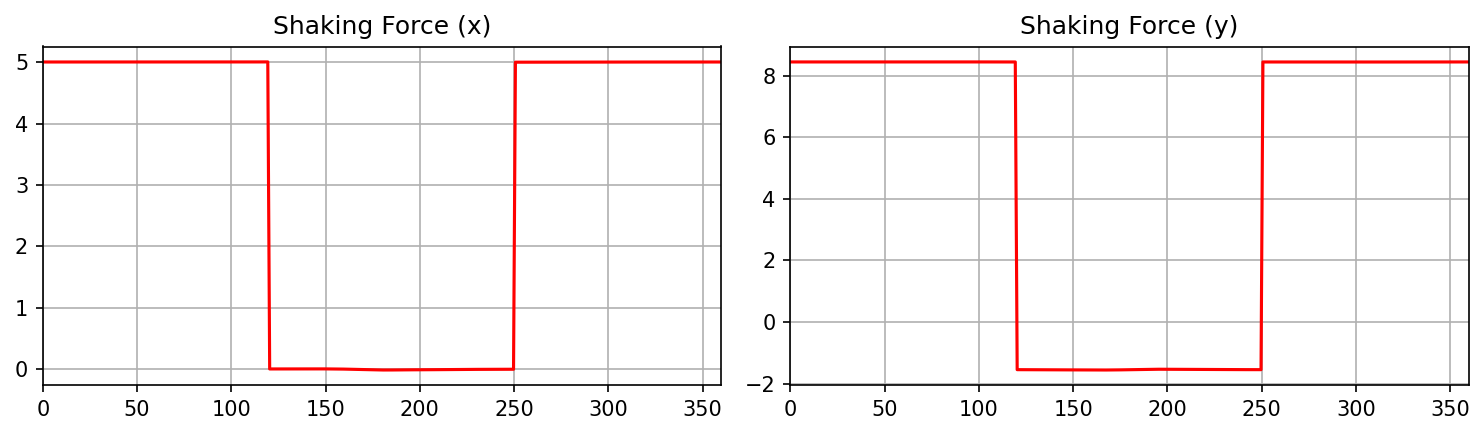

In [8]:
f, axs = plt.subplots(1, 2, figsize=(10, 3))

shake_force = -( force_results["f01"]
               + force_results["f03"]
               + force_results["f05"])

plt.subplot(1,2,1)
plt.title(f"Shaking Force (x)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, shake_force[:, 0], "r")

plt.subplot(1,2,2)
plt.title(f"Shaking Force (y)")
plt.grid("on")
plt.xlim([0, 360])
plt.plot(tm_arr*180/np.pi, shake_force[:, 1], "r")
plt.savefig("../outputs/dynamic_analysis/shaking_force.png")

## Build matrix for printing

In [9]:
mat = np.empty((21,21), dtype=object)
lhs = np.empty((21,1), dtype=object)

for i in range(21):
    for j in range(21):
        if(B[i][j] == 1):
            mat[i][j] = "1"
        elif(B[i][j] == -1):
            mat[i][j] = "-1"
        else:
            mat[i][j] = "0"

for i in range(7):
    for j in range(10):

        yi = f"C_{{{i+1}}}P_{{{joints[j][1]}y}}"
        xi = f"C_{{{i+1}}}P_{{{joints[j][1]}x}}"

        # -RyFx + RxFy
        
        if(mat[i+14][j] == "1"):
            mat[i+14][j]    = f"{yi}"
            mat[i+14][j+10] = f"-{xi}"
        elif(mat[i+14][j] == "-1"):
            mat[i+14][j]    = f"-{yi}"
            mat[i+14][j+10] = f"{xi}"            
mat[14][20] = "1"

for i in range(10):
    lhs[i, 0] = f"F_{{{force_idx[i][0]}{force_idx[i][1]}x}}"
    lhs[i+10, 0] = f"F_{{{force_idx[i][0]}{force_idx[i][1]}y}}"

lhs[20, 0] = "T_{01}" 

rhs = np.array([["m_{1}a_{1x}"],
               ["m_{2}a_{2x}"],
               ["m_{3}a_{3x}"],
               ["m_{4}a_{4x}"],
               ["m_{5}a_{5x}"],
               ["m_{6}a_{6x} - F_{x}"],
               ["m_{7}a_{7x}"],
               ["m_{1}(a_{1y}+g)"],
               ["m_{2}(a_{2y}+g)"],
               ["m_{3}(a_{3y}+g)"],
               ["m_{4}(a_{4y}+g)"],
               ["m_{5}(a_{5y}+g)"],
               ["m_{6}(a_{6y}+g) - F_{y}"],
               ["m_{7}(a_{7y}+g)"],
               ["I_{1} \alpha_{1}"],
               ["I_{2} \alpha_{2}"],
               ["I_{3} \alpha_{3}"],
               ["I_{4} \alpha_{4}"],
               ["I_{5} \alpha_{5}"],
               ["I_{6} \alpha_{6} - (C_{6}P_{7x}F_{y} - C_{6}P_{7y}F_{x})"],
               ["I_{7} \alpha_{7}"],
               ]
               , dtype=object)

mat = pd.DataFrame(mat)
mat_l = mat.to_latex(index=False)
mat_l = mat_l.replace("tabular", "matrix")

lhs = pd.DataFrame(lhs)
lhs_l = lhs.to_latex(index=False)
lhs_l = lhs_l.replace("tabular", "matrix")

rhs = pd.DataFrame(rhs)
rhs_l = rhs.to_latex(index=False)
rhs_l =rhs_l.replace("tabular", "matrix")

In [10]:
with open('../outputs/dynamic_analysis/mat.tex', 'w') as f:
    f.write(mat_l)
with open('../outputs/dynamic_analysis/lhs.tex', 'w') as f:
    f.write(lhs_l)
with open('../outputs/dynamic_analysis/rhs.tex', 'w') as f:
    f.write(rhs_l)